### NBA MVP Statistical Evolution (2015–2024)
**Project Notebook:** MVP Profiles in Context — Statistical Evolution and Changing Archetypes

**Data Source:** basketball-reference.com

**Notebook Focus:**
This notebook investigates how the statistical profiles of NBA Most Valuable Players (MVPs) have changed from 2015 to 2024. By analyzing metrics like points, assists, rebounds, shooting efficiency, and advanced stats, this work aims to answer the question:

    How have MVP winners' stat profiles changed over time, and what does this say about evolving MVP criteria and player archetypes?

This is one part of a larger group project examining how various aspects of NBA gameplay, recognition, and player roles have shifted in the modern era.

**What's Included:**
- Scrapes and processes MVP and league-wide data from 2015 to 2024

- Visualizes trends in offense, defense, and efficiency across MVPs

- Categorizes MVPs by archetype (e.g., Scorer, All-Around, Balanced, Defensive)

- Compares MVPs to their closest vote-getters (2nd and 3rd place)

- Analyzes how MVPs outperform league-wide averages across key stats

- Reflects on how these patterns illustrate a broader shift in what it means to be “Most Valuable” in the modern NBA

**Technical Features and Tools Used:**
- Web scraping with pandas.read_html to pull structured tables from Basketball Reference (no manual downloads)

- Dynamic season-based looping to collect and process yearly data (2015–2024) for MVPs and league-wide players

- Data cleaning and transformation:

    - Merging multi-level headers

    - Standardizing column names

    - Converting stats to numeric types

- Archetype classification using apply() with custom logic to group MVPs into role-based categories

- Z-score normalization to analyze standardized performance across metrics

- Data reshaping using melt() for multi-variable time-series visualizations

- Grouping and aggregation with groupby() to calculate average stats by MVP rank

- Automated saving of plots and CSVs into structured folders (Julissa_Visuals/)

- Custom visualizations using:

    - matplotlib and seaborn for trendlines, comparisons, and radar charts

    - Customized bar plots with stat comparisons, regression overlays, and labeled annotations



### Section 1: Setup

**1.1 Import Libraries**

In [61]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import os 
import time 
from math import pi


**1.2 Create Folder for Output(s)**

In [34]:
# Folder to save output visuals
os.makedirs("Julissa_Visuals/CSV_Exports", exist_ok=True)
os.makedirs("Julissa_Visuals/Plots", exist_ok=True)

### SECTION 2: Load & Clean MVP Data

**2.1 Scrape MVP Table**

In [36]:
### DATA LOADING ###
# Scraping wedsite data for MVP data using pandas (pandas.read_html)

# Define the URL with MVP data
mvp_url = "https://www.basketball-reference.com/awards/mvp.html"

# Use pandas to read all tables from the page
mvp_tables = pd.read_html(mvp_url)

# Extract the first table (MVP winners) being that this table fits the timeframe of this project
mvp_df = mvp_tables[0]

print(mvp_df.head())

  Unnamed: 0_level_0 Unnamed: 1_level_0       Unnamed: 2_level_0  \
              Season                 Lg                   Player   
0            2024-25                NBA  Shai Gilgeous-Alexander   
1            2023-24                NBA             Nikola Jokić   
2            2022-23                NBA              Joel Embiid   
3            2021-22                NBA             Nikola Jokić   
4            2020-21                NBA             Nikola Jokić   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
              Voting                Age                 Tm                  G   
0                (V)                 26                OKC                 76   
1                (V)                 28                DEN                 79   
2                (V)                 28                PHI                 66   
3                (V)                 26                DEN                 74   
4                (V)                 

**2.2 Clean MVP Table Columns**

In [37]:
### CLEANING DATA ###
# Combine multi-level column headers into single strings

# Create an empty list for the new column names
new_columns = []
# Loop through each of the column headers in the DataFrame
for col in mvp_df.columns:
    # Check if the column header is a tuple (multi-level)
    if isinstance(col, tuple):
        # Join the multi-level column names with an underscore
        # split('_') is used to split into individual components where there's an underscore
        new_col = '_'.join(col).strip()
    else:
        # If it's not a tuple, just use the column name as is
        new_col = col
    # Append the new column name to the list
    new_columns.append(new_col)

# Replace the original column names with the new merged names
mvp_df.columns = new_columns

print(mvp_df.columns)

# Clean column names to remove "Unnamed: level_0_" prefix
clean_columns = []
for col in mvp_df.columns:
    if col.startswith('Unnamed:'):
        # Split by '_' and take the last part as the clean column name
        clean_col = col.split('_')[-1]
    else:
        clean_col = col
    clean_columns.append(clean_col)

# Assign cleaned names back to dataframe columns
mvp_df.columns = clean_columns

# Print to verify the cleaned column names
print(mvp_df.columns)

Index(['Unnamed: 0_level_0_Season', 'Unnamed: 1_level_0_Lg',
       'Unnamed: 2_level_0_Player', 'Unnamed: 3_level_0_Voting',
       'Unnamed: 4_level_0_Age', 'Unnamed: 5_level_0_Tm',
       'Unnamed: 6_level_0_G', 'Per Game_MP', 'Per Game_PTS', 'Per Game_TRB',
       'Per Game_AST', 'Per Game_STL', 'Per Game_BLK', 'Shooting_FG%',
       'Shooting_3P%', 'Shooting_FT%', 'Advanced_WS', 'Advanced_WS/48'],
      dtype='object')
Index(['Season', 'Lg', 'Player', 'Voting', 'Age', 'Tm', 'G', 'Per Game_MP',
       'Per Game_PTS', 'Per Game_TRB', 'Per Game_AST', 'Per Game_STL',
       'Per Game_BLK', 'Shooting_FG%', 'Shooting_3P%', 'Shooting_FT%',
       'Advanced_WS', 'Advanced_WS/48'],
      dtype='object')


**2.3 Rename & Filter for Seasons 2015–2024**

In [38]:
# Further simplify column names
rename_map = {
    'Lg': 'League',
    'Tm': 'Team',
    'G': 'GamesPlayed',
    'Per Game_MP': 'MinutesPerGame',
    'Per Game_PTS': 'PointsPerGame',
    'Per Game_TRB': 'ReboundsPerGame',
    'Per Game_AST': 'AssistsPerGame',
    'Per Game_STL': 'StealsPerGame',
    'Per Game_BLK': 'BlocksPerGame',
    'Shooting_FG%': 'FieldGoal%',
    'Shooting_3P%': 'ThreePoint%',
    'Shooting_FT%': 'FreeThrow%',
    'Advanced_WS': 'WinShares',
    'Advanced_WS/48': 'WSPer48'
}

mvp_df.rename(columns=rename_map, inplace=True)

# Check updated column names
print(mvp_df.columns)


Index(['Season', 'League', 'Player', 'Voting', 'Age', 'Team', 'GamesPlayed',
       'MinutesPerGame', 'PointsPerGame', 'ReboundsPerGame', 'AssistsPerGame',
       'StealsPerGame', 'BlocksPerGame', 'FieldGoal%', 'ThreePoint%',
       'FreeThrow%', 'WinShares', 'WSPer48'],
      dtype='object')


In [ ]:
### Filter and Export Data ###

# Filter only seasons between 2015 and 2024
mvp_df = mvp_df[mvp_df['Season'].str[:4].astype(int).between(2015, 2024)].copy()

# Reset index for cleanliness
mvp_df.reset_index(drop=True, inplace=True)

# Save cleaned MVP data
mvp_df.to_csv("Julissa_Visuals/CSV_Exports/mvp_cleaned.csv", index=False)

# Preview the cleaned and filtered data
print(mvp_df.head())


### SECTION 3: VISUALIZING MVP STAT DISTRIBUTIONS

In [ ]:
# Define the stats to analyze
stats_to_plot = {
    'PointsPerGame': 'Points per game reflect a player’s scoring ability. High PPG often correlates with MVP consideration.',
    'AssistsPerGame': 'Assists per game highlight playmaking and the ability to create scoring opportunities for teammates.',
    'ReboundsPerGame': 'Rebounds per game show a player’s involvement in gaining possession and ending opponent possessions.',
    'StealsPerGame': 'Steals per game can indicate defensive quickness and anticipation.',
    'BlocksPerGame': 'Blocks per game often reflect rim protection and defensive presence.',
    'MinutesPerGame': 'Minutes played shows workload and how crucial a player is to their team.',
    'FieldGoal%': 'Field goal percentage shows overall scoring efficiency from the field.',
    'ThreePoint%': 'Three-point percentage reveals how effective MVPs are from beyond the arc.',
    'FreeThrow%': 'Free throw percentage can highlight a player’s consistency and technique.',
    'WinShares': 'Win Shares estimates a player’s contribution to team wins — higher values often correlate with MVP status.',
    'WSPer48': 'Win Shares per 48 minutes adjusts contributions based on playing time — useful for comparing across roles.'
}

# Loop through each stat
for stat, description in stats_to_plot.items():
    # Plotting the distribution of each stat
    sns.histplot(mvp_df[stat], bins=10, kde=True)
    plt.title(f'Distribution of {stat} (MVPs 2015–2024)')
    plt.xlabel(stat)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.figtext(0.5, -0.1, description, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.savefig(f"Julissa_Visuals/Plots/{stat}_distribution.png")
    plt.show()


**3.1 Offensive Trends Over Time**

In [ ]:
# Define offense-related stats and descriptions
offense_stats = {
    'PointsPerGame': 'Points per game reflect scoring ability, a major MVP criterion.',
    'AssistsPerGame': 'Assists show playmaking and how often a player sets up teammates.',
    'MinutesPerGame': 'Minutes reflect player usage — MVPs are usually on the court a lot.'
}

# Ensure numeric conversion for offense stats
# Convert the relevant columns to numeric, forcing errors to NaN
mvp_df[list(offense_stats.keys())] = mvp_df[list(offense_stats.keys())].apply(pd.to_numeric, errors='coerce')

# Plot each stat separately
for stat, description in offense_stats.items():
    sns.lineplot(data=mvp_df, x='Season', y=stat, marker='o')
    plt.title(f"{stat} Over Time (2015–2024 MVPs)")
    plt.xlabel("Season")
    plt.ylabel(stat)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.figtext(0.5, -0.1, description, wrap=True, ha='center', fontsize=9)
    plt.tight_layout()
    plt.savefig(f"Julissa_Visuals/Plots/mvp_{stat}_trend.png")
    plt.show()


**3.2 Defensive Trends Over Time**

In [ ]:
# Define defense-related stats and descriptions
defense_stats = {
    'ReboundsPerGame': 'Rebounding ability shows control of the boards.',
    'StealsPerGame': 'Steals reflect defensive pressure and anticipation.',
    'BlocksPerGame': 'Blocks indicate rim protection and inside defense.'
}

# Ensure numeric
mvp_df[list(defense_stats.keys())] = mvp_df[list(defense_stats.keys())].apply(pd.to_numeric, errors='coerce')

# Plot each stat separately
for stat, description in defense_stats.items():
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=mvp_df, x='Season', y=stat, marker='o')
    plt.title(f"{stat} Over Time (2015–2024 MVPs)")
    plt.xlabel("Season")
    plt.ylabel(stat)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.figtext(0.5, -0.1, description, wrap=True, ha='center', fontsize=9)
    plt.tight_layout()
    plt.savefig(f"Julissa_Visuals/Plots/mvp_{stat}_trend.png")
    plt.show()

**3.3 Efficiency Trends Over Time**

In [ ]:
# Define efficiency-related stats and descriptions
efficiency_stats = {
    'FieldGoal%': 'Field goal percentage shows general shooting accuracy.',
    'ThreePoint%': 'Three-point percentage reflects range and perimeter skill.',
    'FreeThrow%': 'Free throw percentage often reflects form and clutch reliability.'
}

# Ensure numeric
mvp_df[list(efficiency_stats.keys())] = mvp_df[list(efficiency_stats.keys())].apply(pd.to_numeric, errors='coerce')

# Plot each stat separately
for stat, description in efficiency_stats.items():
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=mvp_df, x='Season', y=stat, marker='o')
    plt.title(f"{stat} Over Time (2015–2024 MVPs)")
    plt.xlabel("Season")
    plt.ylabel("Percentage")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.figtext(0.5, -0.1, description, wrap=True, ha='center', fontsize=9)
    plt.tight_layout()
    plt.savefig(f"Julissa_Visuals/Plots/mvp_{stat}_trend.png")
    plt.show()

**3.4 Advanced Metrics Trends**

In [ ]:
# Define advanced metrics and their descriptions
advanced_stats = {
    'WinShares': 'Win Shares estimate how much a player contributed to team wins.',
    'WSPer48': 'Win Shares per 48 minutes adjust contributions for playing time — efficiency per minute.'
}

# Ensure numeric
mvp_df[list(advanced_stats.keys())] = mvp_df[list(advanced_stats.keys())].apply(pd.to_numeric, errors='coerce')

# Plot each stat separately
for stat, description in advanced_stats.items():
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=mvp_df, x='Season', y=stat, marker='o')
    plt.title(f"{stat} Over Time (2015–2024 MVPs)")
    plt.xlabel("Season")
    plt.ylabel(stat)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.figtext(0.5, -0.1, description, wrap=True, ha='center', fontsize=9)
    plt.tight_layout()
    plt.savefig(f"Julissa_Visuals/Plots/mvp_{stat}_trend.png")
    plt.show()

**3.5 Z-Score Transformation**

Standardizing MVP stats to reveal how stat profiles deviate from the norm

**3.5.1 Z-Score: Offensive Stats**

In [ ]:
category_stats = ['PointsPerGame', 'AssistsPerGame', 'MinutesPerGame']

plt.figure(figsize=(12, 6))
for stat in category_stats:
    sns.lineplot(data=z_df, x='Season', y=stat, marker='o', label=stat)

plt.title("Standardized Offensive MVP Stats (Z-Scores, 2015–2024)")
plt.xlabel("Season")
plt.ylabel("Z-Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Julissa_Visuals/Plots/mvp_zscore_offense_trends.png")
plt.show()

**3.5.2 Z-Score: Defensive Stats**

In [ ]:
category_stats = ['ReboundsPerGame', 'StealsPerGame', 'BlocksPerGame']

plt.figure(figsize=(12, 6))
for stat in category_stats:
    sns.lineplot(data=z_df, x='Season', y=stat, marker='o', label=stat)

plt.title("Standardized Defensive MVP Stats (Z-Scores, 2015–2024)")
plt.xlabel("Season")
plt.ylabel("Z-Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Julissa_Visuals/Plots/mvp_zscore_defense_trends.png")
plt.show()

**3.5.3 Z-Score: Efficiency Stats**

In [ ]:
category_stats = ['FieldGoal%', 'ThreePoint%', 'FreeThrow%']

plt.figure(figsize=(12, 6))
for stat in category_stats:
    sns.lineplot(data=z_df, x='Season', y=stat, marker='o', label=stat)

plt.title("Standardized Shooting Efficiency (Z-Scores, 2015–2024)")
plt.xlabel("Season")
plt.ylabel("Z-Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Julissa_Visuals/Plots/mvp_zscore_efficiency_trends.png")
plt.show()

**3.5.4 Z-Score: Advance Stats**

In [ ]:
category_stats = ['WinShares', 'WSPer48']

plt.figure(figsize=(12, 6))
for stat in category_stats:
    sns.lineplot(data=z_df, x='Season', y=stat, marker='o', label=stat)

plt.title("Standardized Advanced MVP Metrics (Z-Scores, 2015–2024)")
plt.xlabel("Season")
plt.ylabel("Z-Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Julissa_Visuals/Plots/mvp_zscore_advanced_trends.png")
plt.show()


In [ ]:
### Summary Table
# Select only numeric columns for MVP stats
numeric_cols = mvp_df.select_dtypes(include='number').columns

# Create summary statistics
summary_df = mvp_df[numeric_cols].agg(['mean', 'median', 'std', 'min', 'max'])

# Transpose and round the values
summary_df = summary_df.T.round(2)

# Rename the index for clarity (if needed)
summary_df.index.name = 'Stat'

# Save the summary table to a CSV file
summary_df.to_csv('mvp_summary_stats.csv')

# Display the summary table
summary_df




**Section 3.6: Correlation Matrix of MVP Stats**

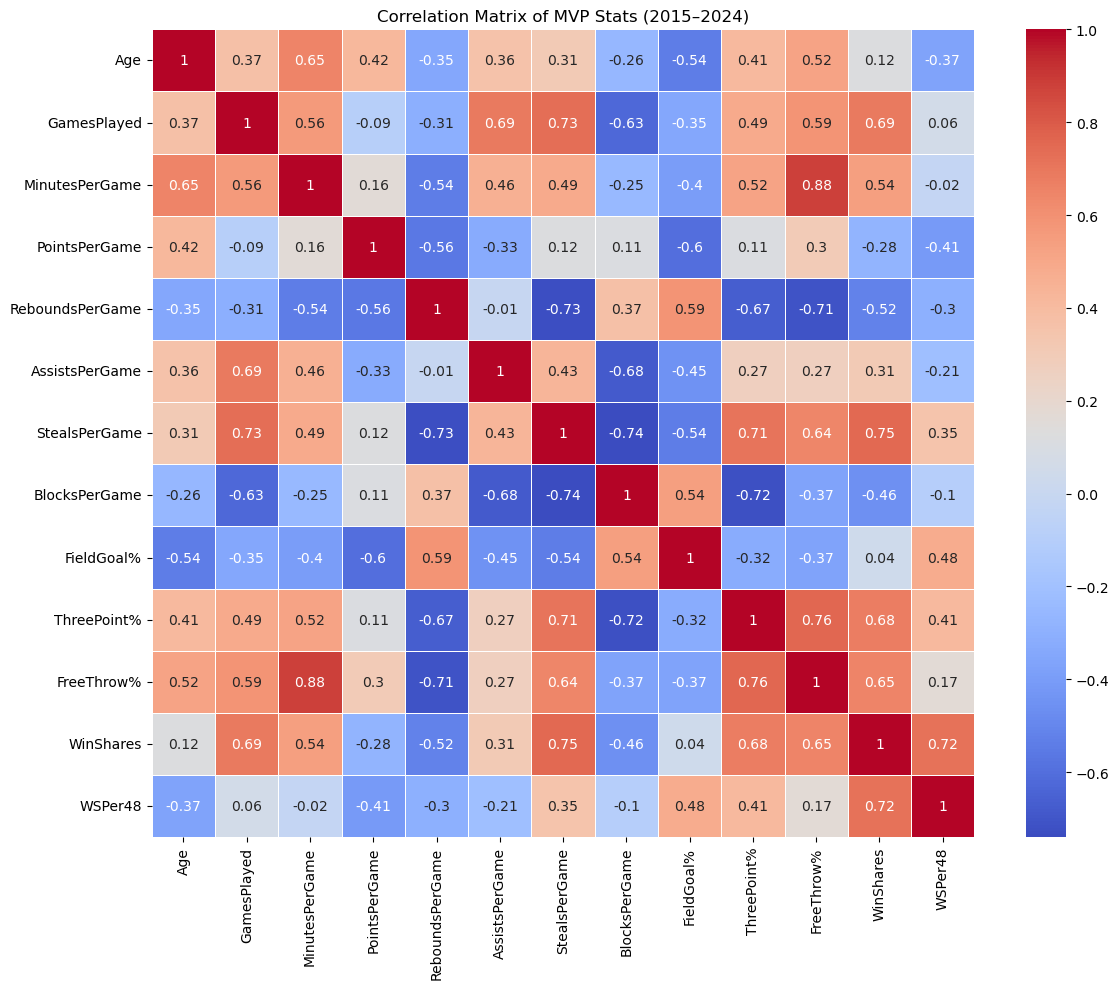

In [ ]:
# Select numeric columns only
numeric_cols = mvp_df.select_dtypes(include='number')

# Compute correlation matrix
correlation = numeric_cols.corr().round(2)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of MVP Stats (2015–2024)")
plt.tight_layout()
plt.savefig("Julissa_Visuals/Plots/mvp_correlation_matrix.png")
plt.show()


In [ ]:
# Create an era label based on season
def classify_era(season_str):
    start_year = int(season_str.split('-')[0])
    return 'Early' if start_year <= 2018 else 'Modern'

mvp_df['Era'] = mvp_df['Season'].apply(classify_era)
# Select only numeric stats
numeric_stats = [
    'PointsPerGame', 'AssistsPerGame', 'ReboundsPerGame',
    'StealsPerGame', 'BlocksPerGame', 'MinutesPerGame',
    'FieldGoal%', 'ThreePoint%', 'FreeThrow%',
    'WinShares', 'WSPer48'
]

# Compute correlation matrices by era
early_corr = mvp_df[mvp_df['Era'] == 'Early'][numeric_stats].astype(float).corr()
modern_corr = mvp_df[mvp_df['Era'] == 'Modern'][numeric_stats].astype(float).corr()

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(early_corr, ax=axes[0], annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar=False)
axes[0].set_title("Correlation (Early Era: 2015–2018)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

sns.heatmap(modern_corr, ax=axes[1], annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar=True)
axes[1].set_title("Correlation (Modern Era: 2019–2024)")
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig("Julissa_Visuals/Plots/mvp_era_correlation_comparison.png")
plt.show()


### Section 4: MVP ARCHETYPES & PLAYER STYLE ANALYSIS

**4.1  MVP Trend Relationship: Points vs Assists (with Regression)**

In [ ]:
# Visualizing the relationship between scoring and playmaking over time (color-coded by season)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=mvp_df,
    x='PointsPerGame',
    y='AssistsPerGame',
    hue='Season',
    palette='plasma',
    s=100,
    edgecolor='black'
)

# Add regression line
sns.regplot(
    data=mvp_df,
    x='PointsPerGame',
    y='AssistsPerGame',
    scatter=False,
    color='gray',
    line_kws={'linewidth': 2, 'linestyle': 'dashed'}
)

# Annotate player names
for _, row in mvp_df.iterrows():
    plt.text(row['PointsPerGame'] + 0.2, row['AssistsPerGame'], row['Player'], fontsize=8, alpha=0.7)

# Labels and formatting
plt.title('MVPs: Points vs Assists per Game (2015–2024)')
plt.xlabel('Points Per Game')
plt.ylabel('Assists Per Game')
plt.grid(True)
plt.tight_layout()
plt.savefig("Julissa_Visuals/Plots/mvp_points_vs_assists_regression.png")
plt.show()

**Section 4.2: Shooting Efficiency vs Overall Value (3P% vs Win Shares)**

In [ ]:
sns.scatterplot(data=mvp_df, x='ThreePoint%', y='WinShares', hue='Season', palette='viridis', s=100)

# Add a regression line
sns.regplot(data=mvp_df, x='ThreePoint%', y='WinShares', scatter=False, color='gray', line_kws={'linewidth': 2, 'linestyle': 'dashed'})

# Improve formatting
plt.title('ThreePoint% vs Win Shares (2015–2024 MVPs)', fontsize=14)
plt.xlabel('Three-Point Percentage')
plt.ylabel('Win Shares')
plt.grid(True)
plt.tight_layout()

# Annotate points with player names
for i, row in mvp_df.iterrows():
    plt.text(row['ThreePoint%'] + 0.002, row['WinShares'] + 0.1, row['Player'], fontsize=9)
plt.savefig("Julissa_Visuals/Plots/mvp_3p_vs_winshares.png")
plt.show()


**Section 4.3: MVP Stat Profile Comparison**

In [ ]:
# Players and stats to compare
players_to_compare = ['Stephen Curry', 'Nikola Jokić']
radar_stats = ['PointsPerGame', 'AssistsPerGame', 'ReboundsPerGame',
               'StealsPerGame', 'BlocksPerGame', 'MinutesPerGame',
               'FieldGoal%', 'ThreePoint%', 'FreeThrow%', 'WinShares', 'WSPer48']

# Filter and prepare Z-score data
radar_data = z_df[z_df['Player'].isin(players_to_compare)][['Player'] + radar_stats]
print(radar_data['Player'].unique())
print(sorted(z_df['Player'].unique()))


# Create angle coordinates
labels = radar_stats
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# Start radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each player
for _, row in radar_data.iterrows():
    values = row[labels].tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, label=row['Player'])
    ax.fill(angles, values, alpha=0.1)

# Radar styling
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Z-Score Radar: Stephen Curry vs Nikola Jokic")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig("Julissa_Visuals/Plots/mvp_radar_curry_vs_jokic.png")
plt.show()

**Section 4.4: Manual Categorization of MVP Styles**

In [ ]:
#Manual Categorization of MVP Styles
#This section manually categorizes MVPs into style types using thresholds for scoring, playmaking, and defense.

# Categorization criteria:
# Scoring MVP: High PPG, low Assists

#All-Around MVP: High across PPG, Assists, Rebounds

#Defensive MVP: High Blocks or Steals

def categorize_mvp(row):
    if row['PointsPerGame'] >= 28 and row['AssistsPerGame'] < 6:
        return 'Scorer'
    elif row['PointsPerGame'] >= 25 and row['AssistsPerGame'] >= 6 and row['ReboundsPerGame'] >= 7:
        return 'All-Around'
    elif row['StealsPerGame'] >= 2 or row['BlocksPerGame'] >= 2:
        return 'Defensive'
    else:
        return 'Balanced'

mvp_df['MVP_Category'] = mvp_df.apply(categorize_mvp, axis=1)
print(mvp_df[['Player', 'Season', 'MVP_Category']])


**Section 4.5: Scoring Style – Efficiency vs Volume**

In [ ]:
sns.scatterplot(data=mvp_df, x='FieldGoal%', y='PointsPerGame', hue='Season', palette='coolwarm', s=100)

# Add regression line
sns.regplot(data=mvp_df, x='FieldGoal%', y='PointsPerGame', scatter=False, color='gray', line_kws={'linestyle': 'dashed'})

# Label points with player names
for i, row in mvp_df.iterrows():
    plt.text(row['FieldGoal%'] + 0.002, row['PointsPerGame'], row['Player'], fontsize=9)

# Format plot
plt.title('Scoring Efficiency vs Points per Game (2015–2024 MVPs)', fontsize=14)
plt.xlabel('Field Goal %')
plt.ylabel('Points Per Game')
plt.grid(True)
plt.tight_layout()
plt.savefig("Julissa_Visuals/Plots/mvp_fg_vs_ppg.png")
plt.show()


### PART 2: MVP vs Top Vote Getters

**Section 1: Load Top Vote Getters Data vis webscrapping**

In [ ]:
# List of valid season URLs (2015-2025)
urls = [
    "https://www.basketball-reference.com/awards/awards_2015.html",
    "https://www.basketball-reference.com/awards/awards_2016.html",
    "https://www.basketball-reference.com/awards/awards_2017.html",
    "https://www.basketball-reference.com/awards/awards_2018.html",
    "https://www.basketball-reference.com/awards/awards_2019.html",
    "https://www.basketball-reference.com/awards/awards_2020.html",
    "https://www.basketball-reference.com/awards/awards_2021.html",
    "https://www.basketball-reference.com/awards/awards_2022.html",
    "https://www.basketball-reference.com/awards/awards_2023.html",
    "https://www.basketball-reference.com/awards/awards_2024.html",
    "https://www.basketball-reference.com/awards/awards_2025.html"
]

# Initialize an empty list to hold the data
all_mvp_data = []

# Loop through each season's URL and scrape the data
for url in urls:
    try:
        print(f"Processing {url}...")  # Debugging: Check which URL is being processed
        
        # Scrape the table from the URL
        tables = pd.read_html(url)
        
        # Check if we have enough tables (there might be fewer than expected)
        if len(tables) < 2:
            print(f"Warning: No MVP voting table found for {url}")
            continue  # Skip to next URL if the table doesn't exist

        # The MVP voting table is usually the second table on the page
        mvp_votes_df = tables[1]
        
        # Clean the column names by flattening any multi-index columns
        mvp_votes_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else str(col).strip() for col in mvp_votes_df.columns]

        # Extract the season from the URL (e.g., 2015, 2016, ...)
        season = url.split('_')[-1].split('.')[0]
        mvp_votes_df['Season'] = season
        
        # Append the data for this season to the list
        all_mvp_data.append(mvp_votes_df)
        
    except Exception as e:
        print(f"Error processing {url}: {e}")

# Check if data was appended successfully
if len(all_mvp_data) == 0:
    print("No data was scraped. Check the error messages above.")

# Concatenate all season data into one DataFrame if we have data
if len(all_mvp_data) > 0:
    mvp_votes_all_seasons = pd.concat(all_mvp_data, ignore_index=True)
    print(f"Successfully scraped data for {len(all_mvp_data)} seasons.")
    # Show the first few rows to check the result
    mvp_votes_all_seasons.head()
else:
    print("No valid MVP data available for concatenation.")

mvp_votes_all_seasons.columns

**Section 2: Clean data**

In [87]:
# Rename columns to clean them up
mvp_votes_all_seasons = mvp_votes_all_seasons.rename(columns={
    'Unnamed: 1_level_0_Player': 'Player',
    'Voting_Pts Won': 'Pts_Won',
    'Per Game_PTS': 'PointsPerGame',
    'Per Game_AST': 'AssistsPerGame',
    'Per Game_TRB': 'ReboundsPerGame',
    'Advanced_WS': 'WinShares',
    'Advanced_WS/48': 'WSPer48'
})

top3_all_seasons = top3_all_seasons.rename(columns={
    'Per Game_STL': 'StealsPerGame',
    'Per Game_BLK': 'BlocksPerGame'
})

# Convert season to string for consistency and convert Pts_Won to numeric
mvp_votes_all_seasons['Season'] = mvp_votes_all_seasons['Season'].astype(str)
mvp_votes_all_seasons['Pts_Won'] = pd.to_numeric(mvp_votes_all_seasons['Pts_Won'], errors='coerce')


**Section 2.1 Save Full MVP Voting Dataset**

In [ ]:
mvp_votes_all_seasons.to_csv("mvp_votes_all_seasons.csv", index=False)


**Section 3: Filter top 3 vote-getters per season**

In [81]:
top3_all_seasons = (
    mvp_votes_all_seasons
    .groupby('Season', group_keys=False)
    .apply(lambda df: df.sort_values('Pts_Won', ascending=False).head(3))
    .reset_index(drop=True)
)
# Re-add Rank column based on vote points
top3_all_seasons['Rank'] = top3_all_seasons.groupby('Season')['Pts_Won'].rank(ascending=False)



C:\Users\julmo\AppData\Local\Temp\ipykernel_828\3470945112.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sort_values('Pts_Won', ascending=False).head(3))


**Section 3.1: Save csv filr for Top 3 Vote-Getters per Season**

In [ ]:
top3_all_seasons.to_csv("top3_mvp_vote_getters.csv", index=False)


### Section 4: MVP Ranking Comparison - Stat Profiles of the Top Vote_Getters

In [ ]:
# Ensure 'Rank' is numeric
top3_all_seasons['Rank'] = top3_all_seasons['Rank'].astype(int)

# Stats to visualize
stat_cols = ['PointsPerGame', 'AssistsPerGame', 'ReboundsPerGame', 'WinShares', 'WSPer48']

# Group by Rank and calculate averages
rank_stats = top3_all_seasons.groupby('Rank')[stat_cols].mean().round(2)

# Plot
rank_stats.T.plot(kind='bar', figsize=(12, 6))
plt.title('Average Stats by MVP Rank (2015–2024)', fontsize=16)
plt.xlabel('Stat')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.legend(title='MVP Voting Rank', labels=['1st Place', '2nd Place', '3rd Place'])
plt.tight_layout()
plt.grid(axis='y')
plt.savefig("Julissa_Visuals/Plots/mvp_rank_stat_averages.png")
plt.show()

### Section 5: Stat Trends by MVP Rank Over Time 

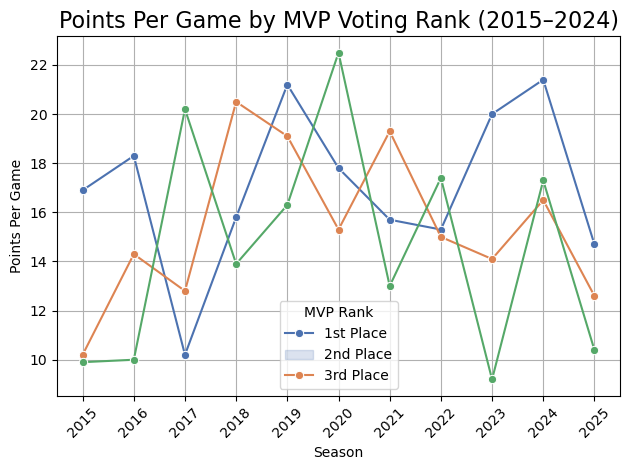

In [83]:
# Plot PointsPerGame by Season and Rank
sns.lineplot(data=top3_all_seasons, x='Season', y='PointsPerGame', hue='Rank', marker='o', palette='deep')

# Formatting
plt.title("Points Per Game by MVP Voting Rank (2015–2024)", fontsize=16)
plt.xlabel("Season")
plt.ylabel("Points Per Game")
plt.xticks(rotation=45)
plt.legend(title="MVP Rank", labels=["1st Place", "2nd Place", "3rd Place"])
plt.grid(True)
plt.tight_layout()
plt.savefig("Julissa_Visuals/Plots/mvp_ppg_by_rank_over_time.png")
plt.show()

### Section 6: Efficiency (WS/48)

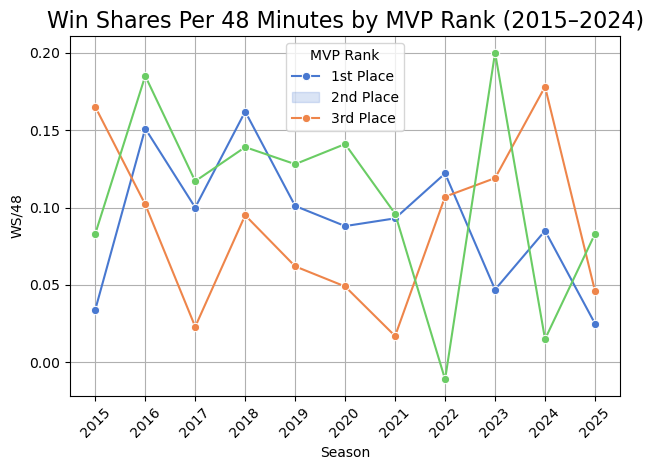

In [84]:
sns.lineplot(data=top3_all_seasons, x='Season', y='WSPer48', hue='Rank', marker='o', palette='muted')

plt.title("Win Shares Per 48 Minutes by MVP Rank (2015–2024)", fontsize=16)
plt.xlabel("Season")
plt.ylabel("WS/48")
plt.xticks(rotation=45)
plt.legend(title="MVP Rank", labels=["1st Place", "2nd Place", "3rd Place"])
plt.grid(True)
plt.tight_layout()
plt.savefig("Julissa_Visuals/Plots/mvp_ws48_by_rank_over_time.png")
plt.show()

### Section 7: Re-apply MVP archetype classification to the top 3 vote-getters

In [88]:
def categorize_mvp(row):
    if row['PointsPerGame'] >= 28 and row['AssistsPerGame'] < 6:
        return 'Scorer'
    elif row['PointsPerGame'] >= 25 and row['AssistsPerGame'] >= 6 and row['ReboundsPerGame'] >= 7:
        return 'All-Around'
    elif row['StealsPerGame'] >= 2 or row['BlocksPerGame'] >= 2:
        return 'Defensive'
    else:
        return 'Balanced'

top3_all_seasons['MVP_Category'] = top3_all_seasons.apply(categorize_mvp, axis=1)


### Section 8: Create the Role vs Rank Table

In [ ]:
# Create a crosstab: counts of MVP Category by Rank
archetype_rank_table = pd.crosstab(top3_all_seasons['MVP_Category'], top3_all_seasons['Rank'])
archetype_rank_table.columns = ['1st Place', '2nd Place', '3rd Place']
archetype_rank_table


## Final Reflections: What Defines an MVP?

In [ ]:
# Correlation Strength as a Proxy for Influence

# Correlation with WinShares
winshare_corr = mvp_df.corr(numeric_only=True)['WinShares'].sort_values(ascending=False)

# Display top influences
print("Correlation with WinShares:\n")
print(winshare_corr)


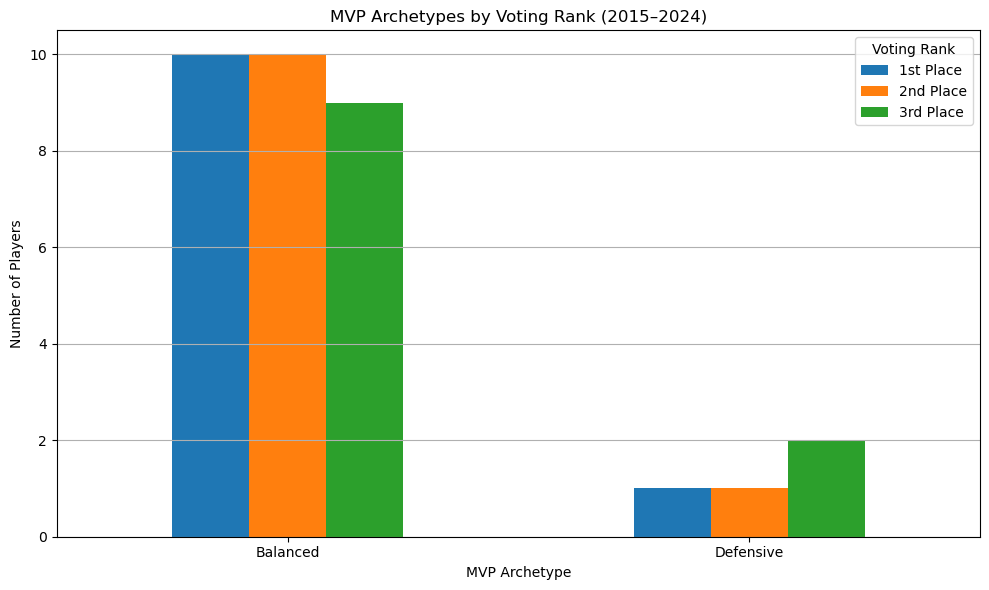

In [90]:
# Plot the result
archetype_rank_table.plot(kind='bar', figsize=(10, 6))
plt.title('MVP Archetypes by Voting Rank (2015–2024)')
plt.ylabel('Number of Players')
plt.xlabel('MVP Archetype')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Voting Rank')
plt.tight_layout()
plt.savefig("Julissa_Visuals/Plots/mvp_archetypes_by_rank.png")
plt.show()


## PART 3: MVP vs. League-Wide Averages 

In [93]:
#  Download league-wide player stats (2015–2024)
import time
def fetch_league_stats(start_year=2015, end_year=2024):
    all_league_stats = {}
    for year in range(start_year, end_year + 1):
        url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html"
        try:
            df = pd.read_html(url)[0]
            df = df[df['Player'] != 'Player']
            df = df.dropna(subset=['PTS'])
            for col in df.columns[5:]:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            all_league_stats[year] = df
            print(f"Loaded stats for {year}")
        except Exception as e:
            print(f"Failed to load {year}: {e}")
        time.sleep(1)  # Be polite to the server
    return all_league_stats

league_stats = fetch_league_stats()


Loaded stats for 2015
Loaded stats for 2016
Loaded stats for 2017
Loaded stats for 2018
Loaded stats for 2019
Loaded stats for 2020
Loaded stats for 2021
Loaded stats for 2022
Loaded stats for 2023
Loaded stats for 2024


In [94]:
# Save data as multiple csv files (for each year)
os.makedirs("Data/league_stats_csv", exist_ok=True)

for year, df in league_stats.items():
    df.to_csv(f"Data/league_stats_csv/NBA_{year}_per_game.csv", index=False)

**Section 1: Select Stats & Match MVP to League Averages**

In [ ]:
# Use clear, full-length stat names
stats_to_compare = {
    'PointsPerGame': 'PTS',
    'AssistsPerGame': 'AST',
    'ReboundsPerGame': 'TRB',
    'StealsPerGame': 'STL',
    'BlocksPerGame': 'BLK',
    'FieldGoalPercentage': 'FG%',
    'ThreePointPercentage': '3P%',
    'FreeThrowPercentage': 'FT%'
}

# Rename columns in MVP DataFrame to match these full names
mvp_df = mvp_df.rename(columns={
    'FieldGoal%': 'FieldGoalPercentage',
    'ThreePoint%': 'ThreePointPercentage',
    'FreeThrow%': 'FreeThrowPercentage'
})

# Build the comparison table
comparison_rows = []

for i, row in mvp_df.iterrows():
    season = row['Season']
    year = int(season.split('-')[1]) + 2000  # from "2014-15" → 2015
    if year not in league_stats:
        continue

    league_df = league_stats[year]
    league_avg = league_df[stats_to_compare.values()].mean()

    comparison = {'Season': season, 'Player': row['Player']}
    for mvp_stat, league_stat in stats_to_compare.items():
        comparison[f"MVP {mvp_stat}"] = row[mvp_stat]
        comparison[f"League Average {mvp_stat}"] = league_avg[league_stat]

    comparison_rows.append(comparison)

# Convert to a DataFrame
mvp_vs_league_df = pd.DataFrame(comparison_rows)

# Preview the result
mvp_vs_league_df


,Season,Player,MVP PointsPerGame,League Average PointsPerGame,MVP AssistsPerGame,League Average AssistsPerGame,MVP ReboundsPerGame,League Average ReboundsPerGame,MVP StealsPerGame,League Average StealsPerGame,MVP BlocksPerGame,League Average BlocksPerGame,MVP FieldGoalPercentage,League Average FieldGoalPercentage,MVP ThreePointPercentage,League Average ThreePointPercentage,MVP FreeThrowPercentage,League Average FreeThrowPercentage
0,2023-24,Nikola Jokić,26.4,8.022313,9.0,1.934150,12.4,3.239184,1.4,0.587347,0.9,0.383946,0.583,0.447558,0.359,0.316925,0.817,0.749670
1,2022-23,Joel Embiid,33.1,8.859057,4.2,2.011782,10.2,3.461708,1.0,0.601767,1.7,0.370545,0.548,0.464241,0.330,0.329798,0.857,0.752586
2,2021-22,Nikola Jokić,27.1,7.812192,7.9,1.808251,13.8,3.331527,1.5,0.582759,0.9,0.353448,0.583,0.434257,0.337,0.303445,0.810,0.747571
3,2020-21,Nikola Jokić,26.4,8.616596,8.3,1.933617,10.8,3.579291,1.3,0.612199,0.7,0.416170,0.566,0.443486,0.388,0.314542,0.868,0.751893
4,2019-20,Giannis Antetokounmpo,29.5,8.461290,5.6,1.843932,13.6,3.563287,1.0,0.617665,1.0,0.398157,0.553,0.442891,0.304,0.313438,0.633,0.743769


**Section 2: MVP vs. League Bar Chart for One Season (e.g., 2023–24)**

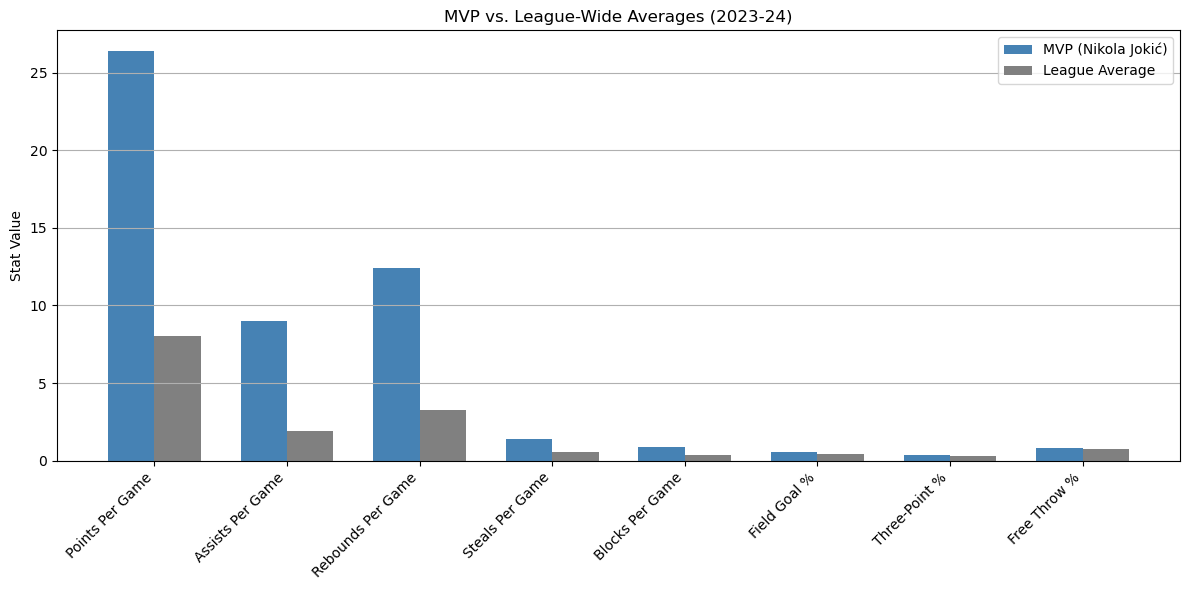

In [99]:
season_row = mvp_vs_league_df[mvp_vs_league_df['Season'] == '2023-24'].iloc[0]

# Full stat labels
labels = [
    "Points Per Game", "Assists Per Game", "Rebounds Per Game",
    "Steals Per Game", "Blocks Per Game",
    "Field Goal %", "Three-Point %", "Free Throw %"
]

# MVP values
mvp_values = [
    season_row['MVP PointsPerGame'],
    season_row['MVP AssistsPerGame'],
    season_row['MVP ReboundsPerGame'],
    season_row['MVP StealsPerGame'],
    season_row['MVP BlocksPerGame'],
    season_row['MVP FieldGoalPercentage'],
    season_row['MVP ThreePointPercentage'],
    season_row['MVP FreeThrowPercentage'],
]

# League average values
league_values = [
    season_row['League Average PointsPerGame'],
    season_row['League Average AssistsPerGame'],
    season_row['League Average ReboundsPerGame'],
    season_row['League Average StealsPerGame'],
    season_row['League Average BlocksPerGame'],
    season_row['League Average FieldGoalPercentage'],
    season_row['League Average ThreePointPercentage'],
    season_row['League Average FreeThrowPercentage'],
]

# Plot
x = range(len(labels))
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x, mvp_values, width=bar_width, label=f"MVP ({season_row['Player']})", color='steelblue')
plt.bar([i + bar_width for i in x], league_values, width=bar_width, label='League Average', color='gray')

plt.xticks([i + bar_width / 2 for i in x],labels, rotation=45, ha='right')
plt.ylabel("Stat Value")
plt.title(f"MVP vs. League-Wide Averages ({season_row['Season']})")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(f"Julissa_Visuals/Plots/mvp_vs_league_{season_row['Season']}.png")
plt.show()


### Future Improvements
